# DA5401 A4: GMM-Based Synthetic Sampling for Imbalanced Data

##### Name : Kaki Hephzi Sunanda
##### Roll Number : DA25M015

**Given Objective:** 

This assignment will challenge you to apply a sophisticated, model-based approach
to tackle the class imbalance problem. You will use a Gaussian Mixture Model (GMM) to
generate synthetic samples for the minority class, and then evaluate its effectiveness compared
to a baseline model. This assignment focuses on the theoretical and practical aspects of
using probabilistic models for data augmentation.

**Problem Statement**:

You are a data scientist tasked with building a fraud detection model for a financial institution. You have been given a highly imbalanced dataset - [Credit Card Fraud Detection Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud), where a tiny fraction of transactions are fraudulent. Your main challenge is to create a training set that allows a classifier to learn the nuances of the minority (fraudulent) class without overfitting or misclassifying. You will implement a GMM-based synthetic data generation pipeline and analyze its impact on model performance.

#### About the Dataset

- The dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
- The dataset is about **credit card transactions** made by European cardholders in **September 2013**.
- These transactions have been recorded over a span of **2 days**.
- It is a **highly imbalanced dataset**, with less than `0.2%` of fraudulent transactions, making fraud detection challenging.
- The total number of transactions in the dataset are: `284,807`
- Total number of fradulent transactions in the dataset are: `492`
- Total number of non-fraudulent transactions are: `284,315`
- Percentage of fraudulent transactions : 
$$\frac{|\text{Fraudulent transactions}|}{|\text{Total Transactions}|} = \left(\frac{492}{284,807}\right) \times 100 \approx 0.173\%$$

<br><br>
The dataset contains the following features:

| Feature  | Description |
|----------|-------------|
| **Time** | Number of seconds elapsed between each transaction and the first transaction in the dataset. |
| **V1–V28** | Numerical features resulting from a **PCA transformation** applied to the original features, to *protect user identities and sensitive details*. |
| **Amount** | The transaction amount|
| **Class** | Target variable: `1` for fraudulent transactions, `0` for non-fraudulent transactions. |


# Tasks

## Part A : Baseline Model and Data Analysis

### Question 1 : Data Loading and Analysis

#### Question 1.1 : Load the <span style="color:#32CD32">creditcard.csv</span> dataset.

In [15]:
# Reset the environment.

%reset -f

In [16]:
# Import necessary libraries.

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Define the file path for the credit card dataset.

data_path = "creditcard.csv"
data = pd.read_csv(data_path)

In [18]:
# Display the dataset.

data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [19]:
# Dimensions of the Dataset.

print(f"Total Number of transactions in the dataset (samples): {data.shape[0]}")
print(f"Number of features in the dataset (including the target variable - Class): {data.shape[1]}")

Total Number of transactions in the dataset (samples): 284807
Number of features in the dataset (including the target variable - Class): 31


#### Question 1.2 : Print the class distribution and discuss the degree of imbalance.

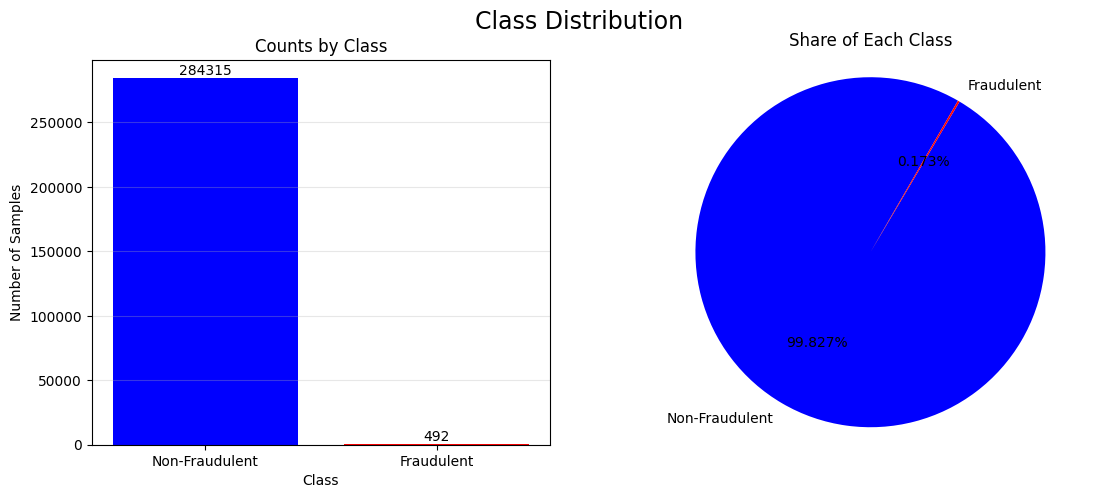

In [20]:
# Plot the Class Distribution of the dataset.

class_map = {0:"Non-Fraudulent", 1:"Fraudulent"} # Mapping from class labels to descriptive strings.
class_colors = ['#0000FF','#FF0000'] # Colors for each class.
class_count = data['Class'].map(class_map).value_counts().reset_index() # Dataframe with counts of each class

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5)) # Create a figure and a set of subplots.
plt.suptitle("Class Distribution", fontsize = 17) # Super title to the plot.

bars = ax[0].bar(class_count['Class'],class_count['count'], color = class_colors) # Bar plot showing class counts.
ax[0].set_title("Counts by Class")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Number of Samples")
ax[0].bar_label(bars)
ax[0].grid(axis='y', alpha=0.3)

ax[1].pie(class_count['count'], labels=class_count['Class'], colors = class_colors, autopct='%1.3f%%', startangle=60) # Pie chart showing class distribution.
ax[1].set_title("Share of Each Class", y=1.015)
ax[1].axis('equal')
plt.show()

- From the above plots, it can be observed that:
    - The dataset is **extremely imbalanced**.
    - There are **`284,315` non-fraudulent transactions** compared to only **`492` fraudulent transactions**.
    - The pie chart shows that fraudulent transactions are **`0.173%`** of the dataset, while non-fraudulent transactions dominate with **`99.827%`**.
<br><br>
- The degree of imbalance is defined as the ratio between the number of majority samples and the number of minority samples.
$$
\text{Degree of Imbalance} = \frac{|majority|}{|minority|} = \frac{284,315}{492} = 577.876 \approx 578
$$

- The dataset has an imbalance ratio of approximately **`578:1`**.

#### EDA

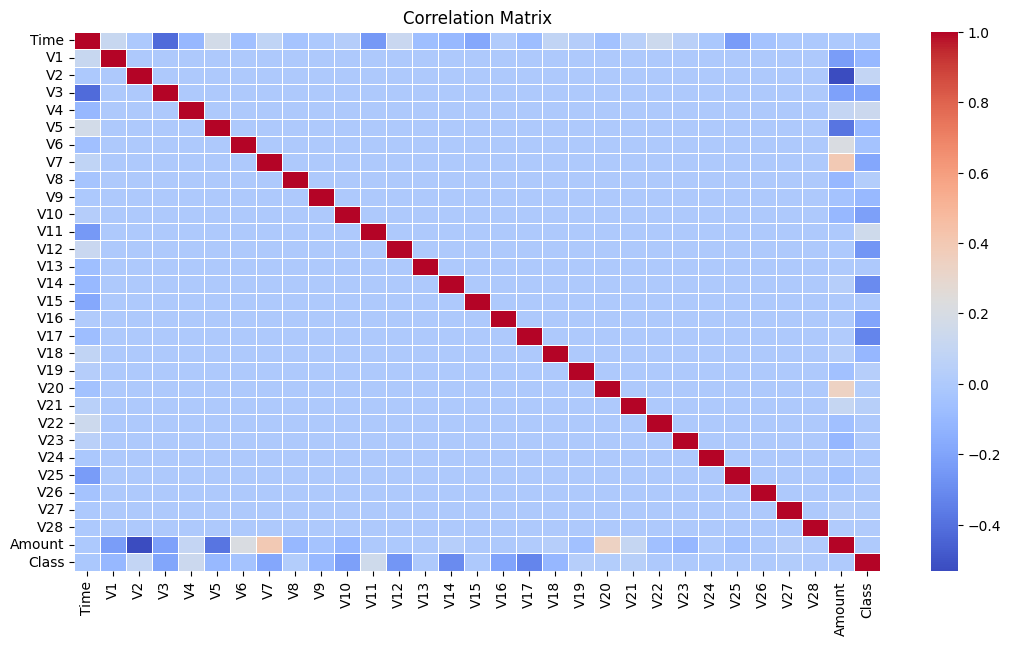

In [21]:
corr_mat = data.corr()
plt.figure(figsize=(13,7))
sns.heatmap(corr_mat, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show();

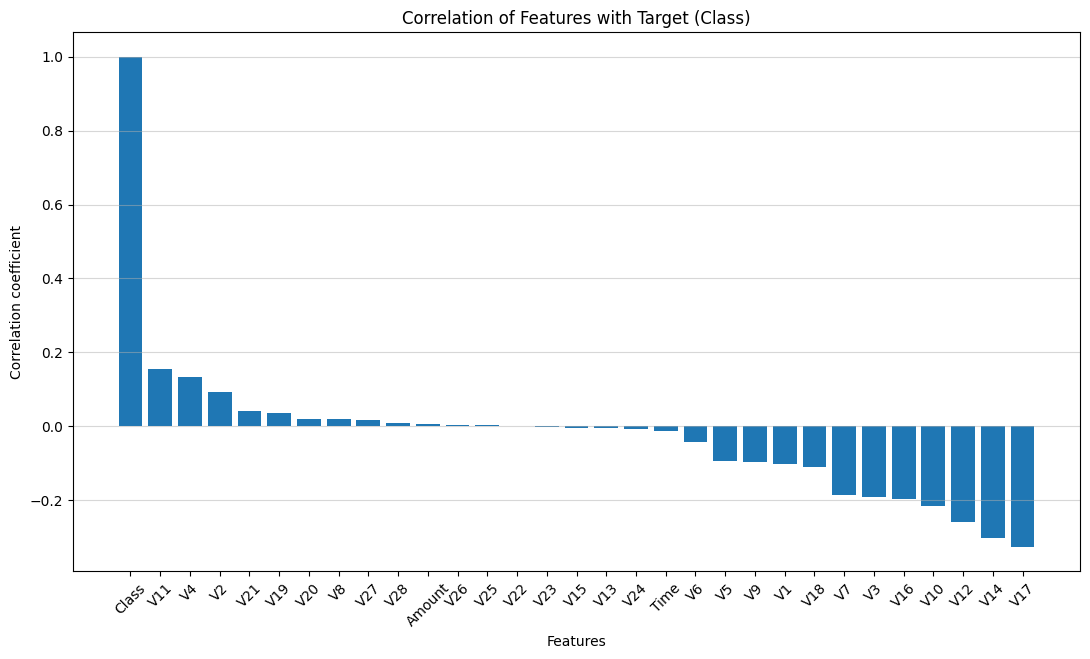

In [22]:
corr_target = corr_mat['Class'].sort_values(ascending=False)
plt.figure(figsize=(13,7))
plt.bar(corr_target.index, corr_target)
plt.xticks(rotation=45)
plt.title("Correlation of Features with Target (Class)")
plt.ylabel("Correlation coefficient")
plt.xlabel("Features")
plt.grid(axis='y', alpha=0.5)
plt.show()

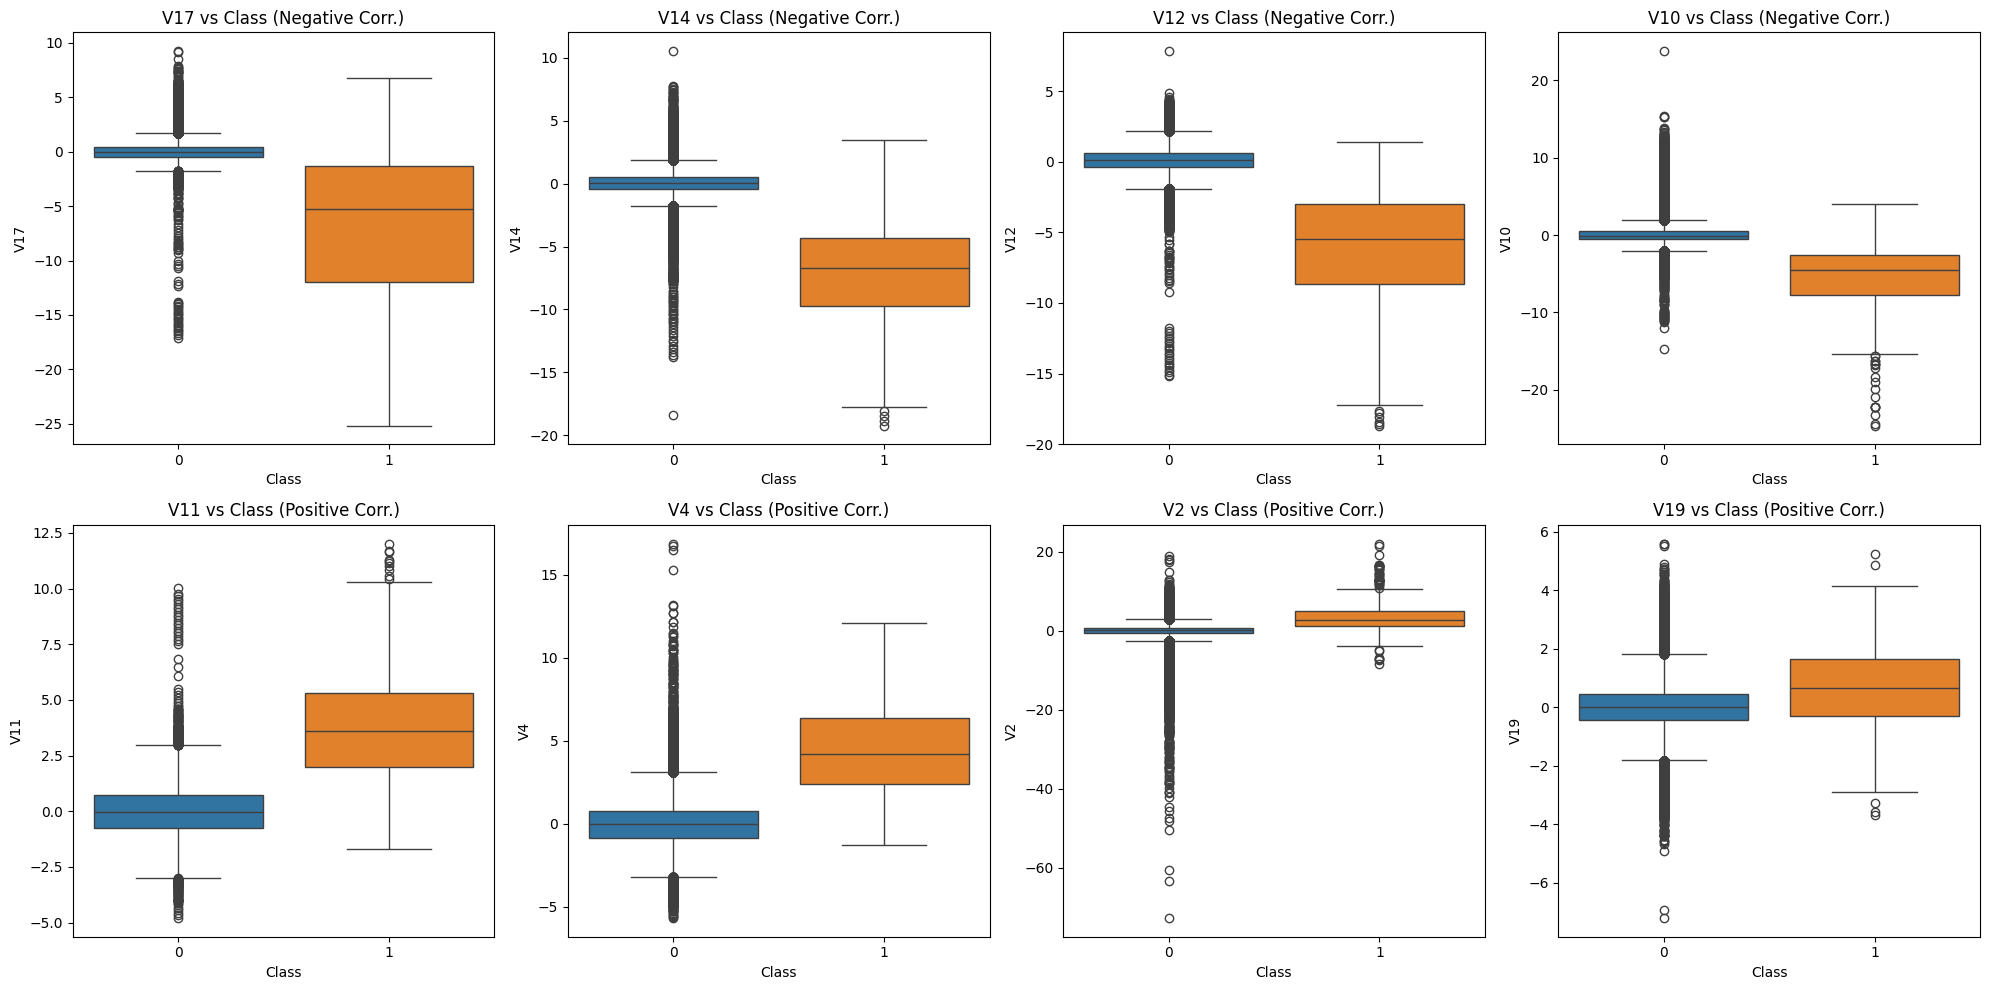

In [23]:
neg_corr_features = ['V17', 'V14', 'V12', 'V10']
pos_corr_features = ['V11', 'V4', 'V2', 'V19']

fig, ax = plt.subplots(2, 4, figsize=(20, 10))

# Row 0: negative correlations
for i, feature in enumerate(neg_corr_features):
    sns.boxplot(
        data=data,
        x="Class", y=feature,
        hue="Class",         # << required so palette mapping makes sense
        dodge=False,         # x and hue are the same; avoid duplicate boxes
        legend=False,
        ax=ax[0, i]
    )
    ax[0, i].set_title(f"{feature} vs Class (Negative Corr.)")
    ax[0, i].set_xlabel("Class"); ax[0, i].set_ylabel(feature)

# Row 1: positive correlations
for i, feature in enumerate(pos_corr_features):
    sns.boxplot(
        data=data,
        x="Class", y=feature,
        hue="Class",
        dodge=False,
        legend=False,
        ax=ax[1, i]
    )
    ax[1, i].set_title(f"{feature} vs Class (Positive Corr.)")
    ax[1, i].set_xlabel("Class"); ax[1, i].set_ylabel(feature)

plt.tight_layout()
plt.show()


Rows before: 284,807  |  after z-filter: 267,489  (93.92% retained)


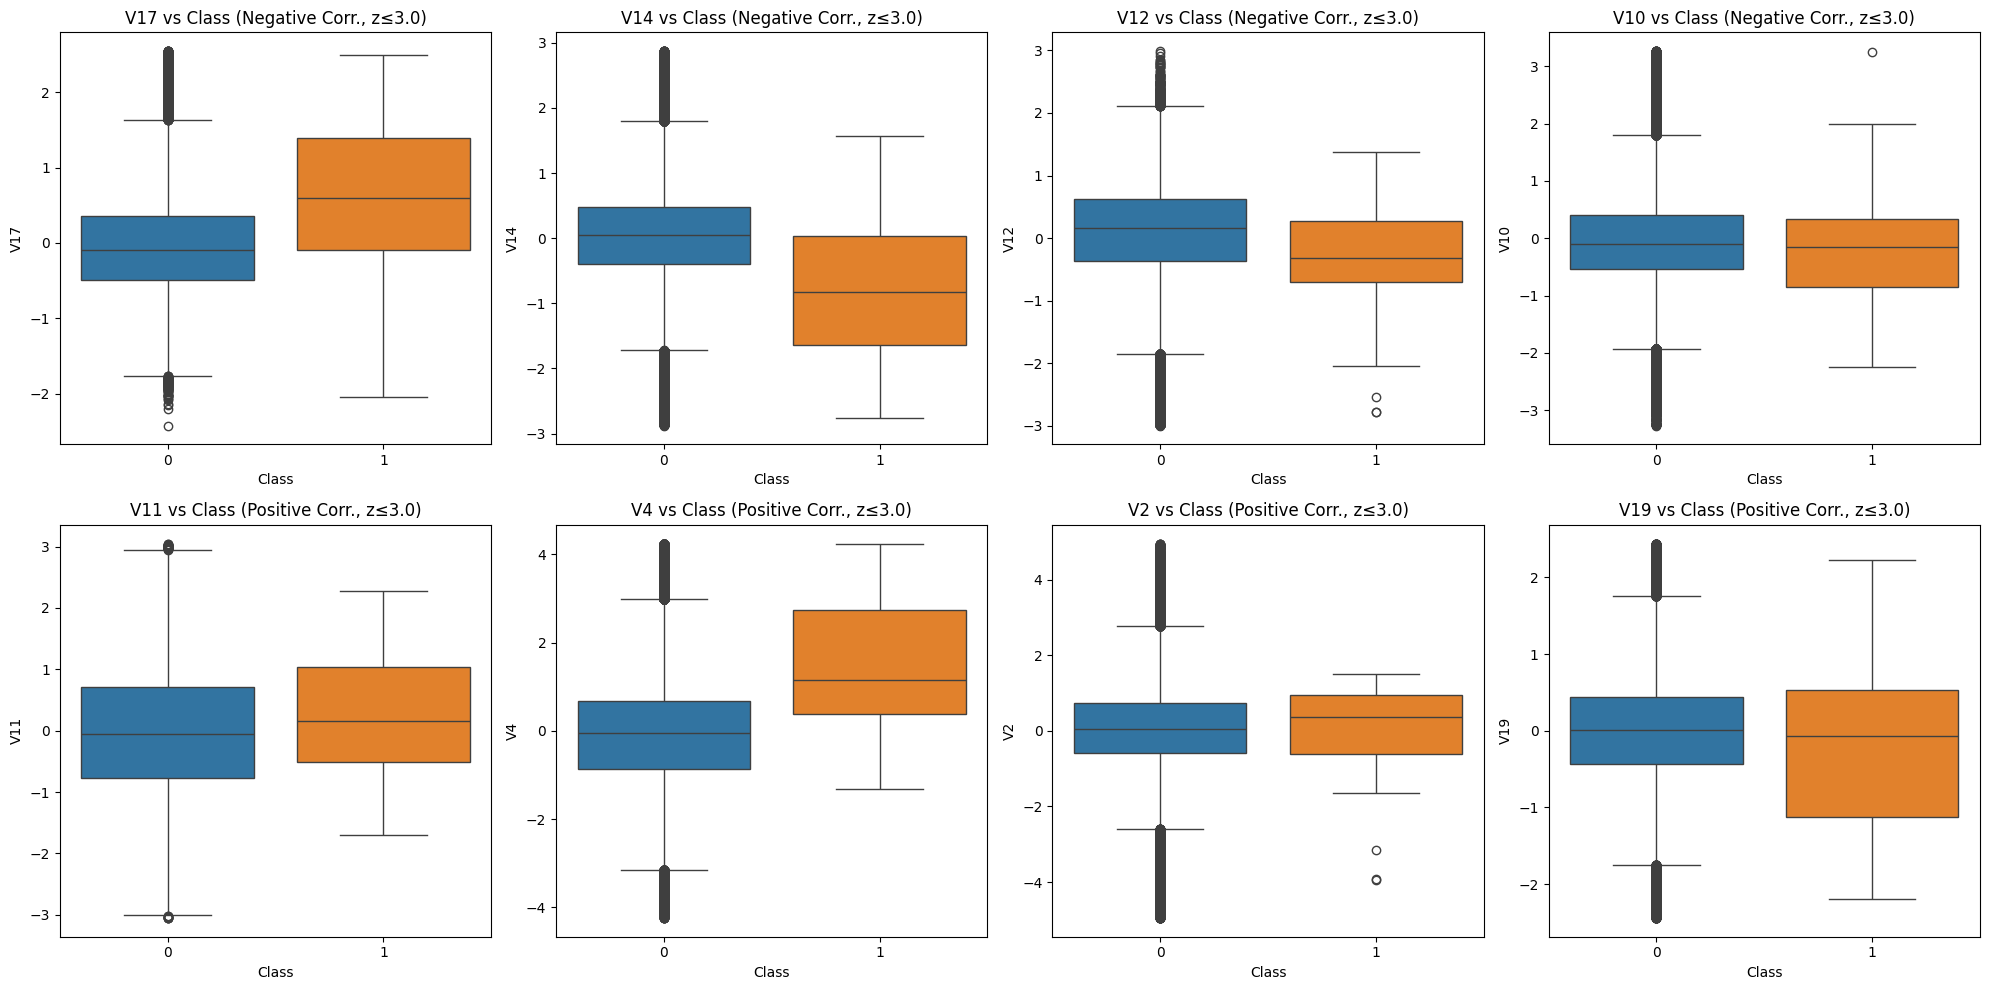

In [24]:
from scipy.stats import zscore

feat_subset = neg_corr_features + pos_corr_features

Z_THRESH = 3.0  

Z = np.abs(pd.DataFrame(
    {col: zscore(data[col], nan_policy='omit') for col in feat_subset},
    index=data.index
))

# keep rows whose all selected-feature z-scores are within threshold
keep_mask = (Z <= Z_THRESH).all(axis=1)

print(f"Rows before: {len(data):,}  |  after z-filter: {keep_mask.sum():,}  "
      f"({100*keep_mask.mean():.2f}% retained)")

# create cleaned DataFrame and (optionally) replace original
data_clean = data.loc[keep_mask].copy()
# data = data_clean  # <-- if you want to *use* the cleaned data going forward

# --------------------------------------------------
# 2) Replot class-conditioned boxplots on cleaned data
# --------------------------------------------------
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

# Row 0: negative correlations
for i, feature in enumerate(neg_corr_features):
    sns.boxplot(
        data=data_clean,
        x="Class", y=feature,
        hue="Class",        # needed for seaborn>=0.13
        dodge=False, legend=False,
        ax=ax[0, i]
    )
    ax[0, i].set_title(f"{feature} vs Class (Negative Corr., z≤{Z_THRESH})")
    ax[0, i].set_xlabel("Class"); ax[0, i].set_ylabel(feature)

# Row 1: positive correlations
for i, feature in enumerate(pos_corr_features):
    sns.boxplot(
        data=data_clean,
        x="Class", y=feature,
        hue="Class",
        dodge=False, legend=False,
        ax=ax[1, i]
    )
    ax[1, i].set_title(f"{feature} vs Class (Positive Corr., z≤{Z_THRESH})")
    ax[1, i].set_xlabel("Class"); ax[1, i].set_ylabel(feature)

plt.tight_layout()
plt.show()


### Question 2 : Model Training

#### Question 2.1 : Split the dataset into training and testing sets. Crucially, the test set should be an accurate reflection of the original class imbalance.

In [25]:
# Import the necessary functions.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features (X) and target variable (y).
X = data.iloc[:,:-1] # Feature data.
y = data.iloc[:,-1] # Target data.

# Split the data into training and testing sets with statification to maitain class imbalance ratio.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Fit scaler on training data.
scaler = StandardScaler().fit(X_train)

# Transform both the training and testing data using the fitted scaler.
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

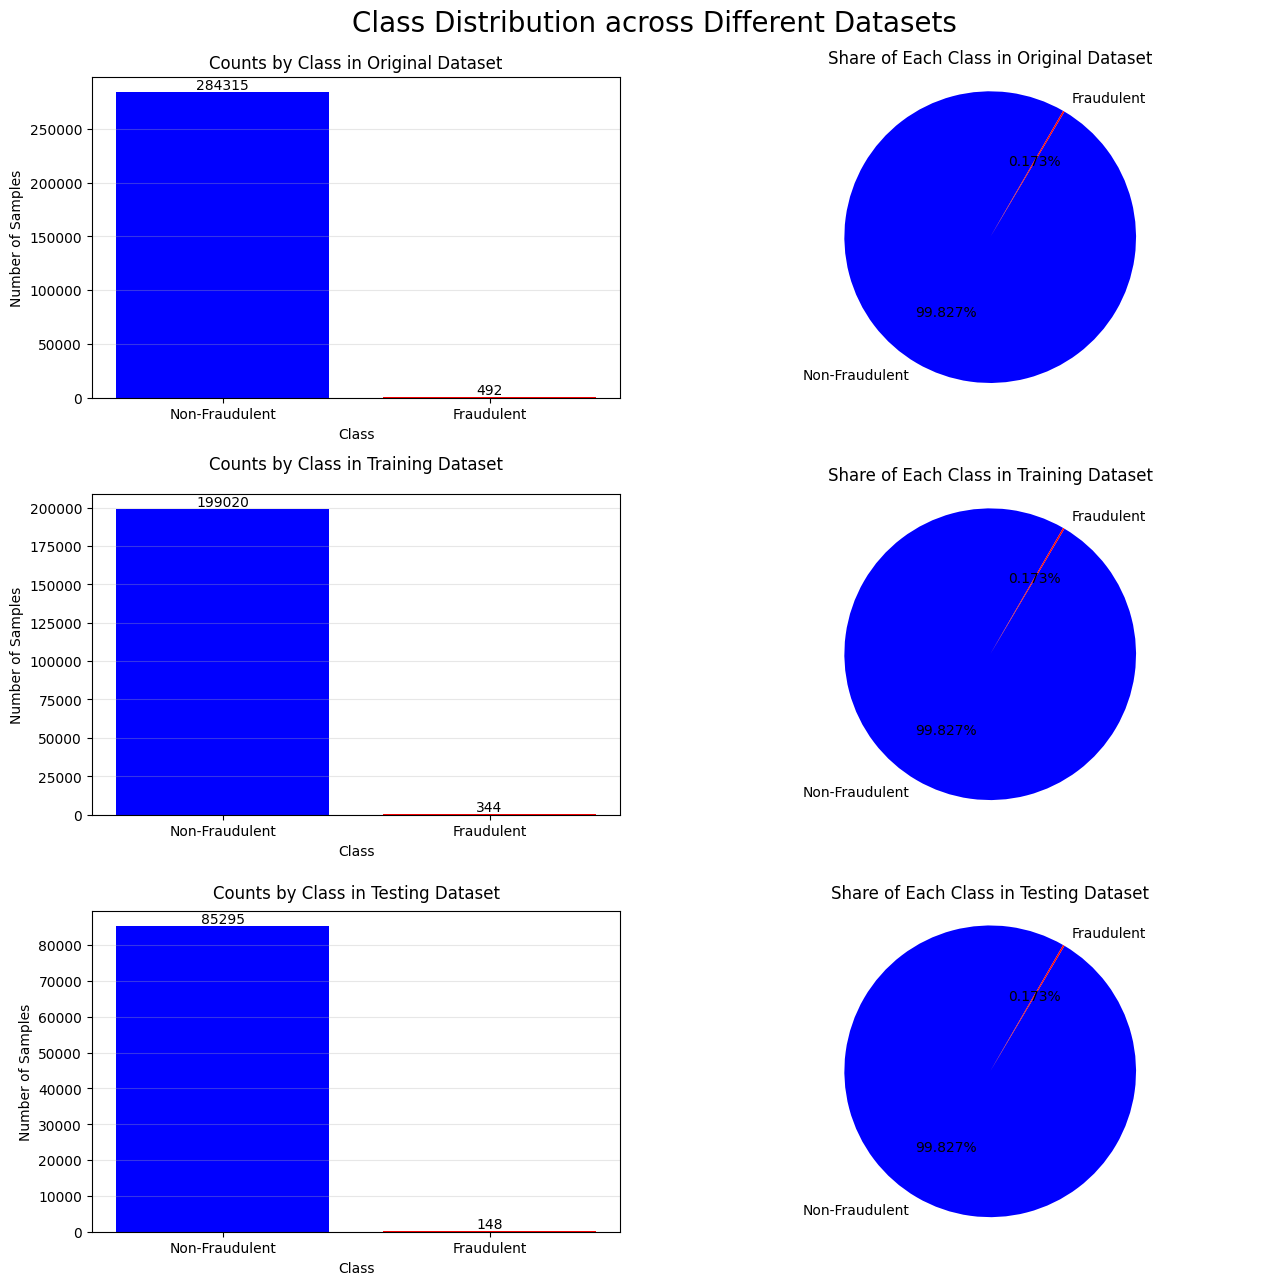

In [26]:
# Plot to show class distribution in Original, Training, and Testing datasets.

# Count class samples in training and testing sets.
train_count = y_train.map(class_map).value_counts().reset_index()
test_count = y_test.map(class_map).value_counts().reset_index()

# Create grid for subplots.
fig, ax = plt.subplots(nrows=3, ncols = 2, figsize=(15,15))
plt.subplots_adjust(hspace=0.3)  # Adjust vertical space between rows.
plt.suptitle("Class Distribution across Different Datasets", y = 0.925,  fontsize=20) # Plot's super title.

# Bar chart of class count for original dataset.
bars = ax[0][0].bar(class_count['Class'], class_count['count'], color = class_colors) 
ax[0][0].set_title("Counts by Class in Original Dataset")
ax[0][0].set_xlabel("Class")
ax[0][0].set_ylabel("Number of Samples")
ax[0][0].bar_label(bars)
ax[0][0].grid(axis='y', alpha=0.3)

# Pie chart of class count for original dataset.
ax[0][1].pie(class_count['count'], labels=class_count['Class'], colors = class_colors, autopct='%1.3f%%', startangle=60) 
ax[0][1].set_title("Share of Each Class in Original Dataset", y=1.015)
ax[0][1].axis('equal')

# Bar chart of class count for training dataset.
bars = ax[1][0].bar(train_count['Class'], train_count['count'], color = class_colors) 
ax[1][0].set_title("Counts by Class in Training Dataset",  y=1.05)
ax[1][0].set_xlabel("Class")
ax[1][0].set_ylabel("Number of Samples")
ax[1][0].bar_label(bars)
ax[1][0].grid(axis='y', alpha=0.3)

# Pie chart of class count for training dataset.
ax[1][1].pie(train_count['count'], labels=train_count['Class'], colors = class_colors, autopct='%1.3f%%', startangle=60) 
ax[1][1].set_title("Share of Each Class in Training Dataset", y=1.015)
ax[1][1].axis('equal')

# Bar chart of class count for testing dataset.
bars = ax[2][0].bar(test_count['Class'], test_count['count'], color = class_colors) 
ax[2][0].set_title("Counts by Class in Testing Dataset", y=1.015)
ax[2][0].set_xlabel("Class")
ax[2][0].set_ylabel("Number of Samples")
ax[2][0].bar_label(bars)
ax[2][0].grid(axis='y', alpha=0.3)

# Pie chart of class count for testing dataset.
ax[2][1].pie(test_count['count'], labels=test_count['Class'], colors = class_colors, autopct='%1.3f%%', startangle=60) 
ax[2][1].set_title("Share of Each Class in Testing Dataset", y=1.015)
ax[2][1].axis('equal')
plt.show()

#### Question 2.2 : Train a Logistic Regression classifier on the imbalanced training data to establish a performance baseline.

In [27]:
# Import necessary modules from scikit-learn.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Initialize a Logistic Regression model. 
baseline_model = LogisticRegression(max_iter=5000, random_state=0)

# Train the Logistic Regression model on the training data.
baseline_model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


### Question 3 : Baseline Evaluation

#### Question 3.1 : Evaluate the model's performance on the test set. Explain why metrics such as Precision, Recall, and F1-score for the minority class are more informative than accuracy for this problem.


Baseline Model Accuracy: 99.91 %

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Classification Report of Baseline Model: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.85      0.61      0.71       148

    accuracy                           1.00     85443
   macro avg       0.92      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



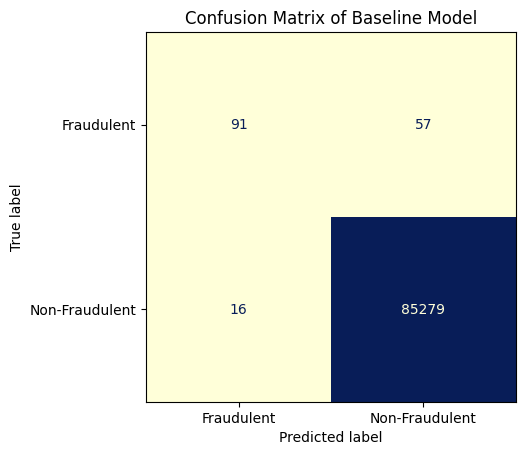

In [28]:
# Import necessary modules from scikit-learn.

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function that evaluates classification model on test data and prints performance metrics.

def model_report(model, xtest, ytest, model_name):
    ypred = model.predict(xtest) # Use the trained model to generate predictions for the test data.
    
    acc = accuracy_score(ytest, ypred)*100 # Calculate accuracy.
    print(f"\n{model_name} Accuracy: {acc:.2f} %\n")
    
    print("~"*55)
    
    clfrep = classification_report(ytest, ypred) # Generate classification report.
    print(f"\nClassification Report of {model_name}: \n\n{clfrep}")
    
    print("~"*70,"\n")
    
    cm = confusion_matrix(y_test, ypred, labels=[1, 0]) # Calculate Confusion Matrix. 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Fraudulent", "Non-Fraudulent"]) # Display the confusion matrix.
    disp.plot(colorbar=False, cmap=plt.cm.YlGnBu) # Plot the confusion matrix.    
    plt.title(f"Confusion Matrix of {model_name}")

model_report(baseline_model, X_test_scaled, y_test, "Baseline Model") # Report for Baseline Model.

<u>**Baseline Model Evaluation :**</u>
- The **overall accuracy** of the baseline model is extremely high at **`99.91%`**.
- From the classification report, it can be observed that:
    - For the **non-fraudulent class (0)**, the model achieves perfect performance with **Precision = `1.00`, Recall = `1.00`, and F1-score = `1.00`**.
    - This is expected since the majority class dominates the dataset.
- For the **fraudulent class (1)**, the performance drops significantly:
    - **Precision = `0.85`**, i.e, out of all transactions predicted as fraud, `85%` are correct.
    - **Recall = `0.61`**, i.e, only `61%` of actual fraud cases are detected.
    - **F1-score = `0.71`**, i.e, there is a moderate balance between precision and recall, but much lower than the majority class.
- The **confusion matrix** also highlights this imbalance clearly:
    - True Negatives (Non-fraud correctly classified): **`85,279`**
    - False Positives (Non-fraud misclassified as fraud): **`16`**
    - False Negatives (Fraud missed as non-fraud): **`57`**
    - True Positives (Fraud correctly identified): **`91`**
- The **false negatives (57 fraud cases missed)** are especially concerning in a fraud detection system, as they represent fraudulent transactions that the model failed to catch.

<br><br>

<u>Reasons why **accuracy** is a misleading metric in this case:</u>
- Accuracy is a misleading metric when evaluating models on imbalanced datasets.
- Since the data is highly imbalanced, accuracy is inflated.
- Accuracy is formulated as : $$\text{Accuracy} = \frac{\text{TP}+\text{TN}}{\text{TP}+\text{TN}+\text{FP}+\text{FP}}$$
- With majority samples being non-fraudulent, predicting most transactions as non-fraud ($\text{TN}$) achieves high accuracy, regardless of how the fraud samples are classified.
- For this reason, Precision, Recall and F1-score are better evaluation metrics for minority class as they are more informative.
    - **Precision** measures how trustworthy a fraud prediction is.
    - **Recall** measures how many frauds the model successfully detects.
    - **F1-score** balances the trade-off between precision and recall.


<br><br>

- While the baseline model achieves nearly perfect accuracy due to class imbalance, it struggles to identify fraud cases effectively, as shown by the reduced recall and F1-score for the fraudulent class.
- Therefore, **metrics like Precision, Recall, and F1-score (specifically for the minority class)** provide a far more realistic assessment of the model’s effectiveness in fraud detection than accuracy alone.


Clean Data Model Accuracy: 99.81 %

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Classification Report of Clean Data Model: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.33      0.12      0.18       148

    accuracy                           1.00     85443
   macro avg       0.67      0.56      0.59     85443
weighted avg       1.00      1.00      1.00     85443

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



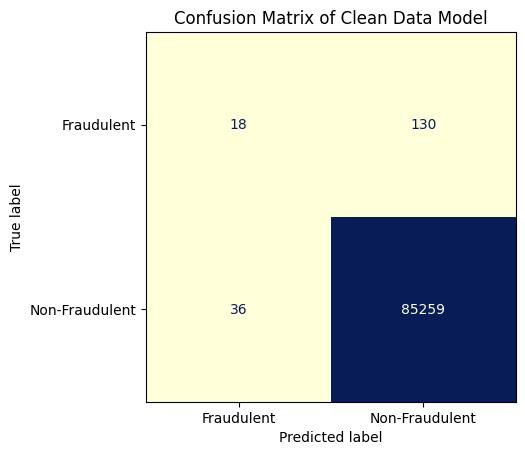

In [36]:
# Import the necessary functions.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features (X) and target variable (y).
X_clean = data_clean.iloc[:,:-1] # Feature data.
y_clean = data_clean.iloc[:,-1] # Target data.

# Split the data into training and testing sets with statification to maitain class imbalance ratio.
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clean, y_clean, test_size=0.3, random_state=42, stratify=y_clean)

# Fit scaler on training data.
scaler_c = StandardScaler().fit(X_train_c)
X_train_scaled_c = scaler_c.transform(X_train_c)
X_test_scaled_c  = scaler_c.transform(X_test)   # <-- original test features

# Train model on cleaned train
baseline_model_c = LogisticRegression(max_iter=10_000, random_state=0)
baseline_model_c.fit(X_train_scaled_c, y_train_c)

# Sanity check and evaluate on the SAME original test labels
assert X_test_scaled_c.shape[0] == y_test.shape[0], "Mismatched test shapes!"
model_report(baseline_model_c, X_test_scaled_c, y_test, "Clean Data Model")

---

## Part B : Gaussian Mixture Model (GMM) for Synthetic Sampling

### Question 1 : Theoretical Foundation

#### Question 1.1 : In a markdown cell, explain the fundamental difference between GMM-based synthetic sampling and simpler methods like SMOTE.

<u> SMOTE (Synthetic Minority Oversampling Technique) </u>:

SMOTE follows these steps for oversampling datapoints:

1. For each minority instance $x_i$, find its *k-nearest neighbors* in the minority class.
2. Randomly select one neighbor $x_j$.
3. Create a new synthetic point along the line segment joining $x_i$ and $x_j$:

$$
x_{\text{new}} = x_i + \delta \cdot (x_j - x_i), \quad \delta \sim U(0,1)
$$

- SMOTE generates samples by **linear interpolation** between neighbors.  
- It does not model the underlying distribution of the data.  
- This model assumes the minority class lies in a **linear, uniform structure**.  
- It is fast and simple, but it can create overlapping or unrealistic points if clusters are non-linear.

<br><br>

<u> GMM-Based Synthetic Sampling</u> :

The steps for generating minority data samples using GMM based synthetic sampling are as follows:
1. Fit a **Gaussian Mixture Model (GMM)** to the minority class data.
   - The GMM represents the probability distribution as:

   $$
   p(x) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)
   $$

   where:
   - $K$ = number of components,  
   - $\pi_k$ = mixture weight of component $k$,  
   - $\mu_k$ = mean vector of component $k$,  
   - $\Sigma_k$ = covariance matrix of component $k$.  

2. To generate one synthetic sample:
   - Choose a component $k$ with probability $\pi_k$.  
   - Sample from the Gaussian distribution:

   $$
   x_{\text{new}} \sim \mathcal{N}(\mu_k, \Sigma_k)
   $$

3. Repeat until the minority class is sufficiently balanced with the majority.


<br><br>

- GMM based synthetic sampling captures **multi-modal, non-linear, clustered** minority distributions.  
- Samples are **probabilistically consistent** with the original data.  
- It requires more computation and careful parameter selection.  
- **SMOTE** is **geometry-based**, it generates synthetic samples through **linear interpolation** between existing points, without modeling the data distribution.  
- **GMM-based sampling** is **model-driven and probabilistic**. It explicitly **learns the statistical distribution** of the minority class and generates samples consistent with that distribution.


#### Question 1.2 : Discuss why GMM is theoretically better at capturing the underlying data distribution, especially when the minority class has multiple sub-groups or complex shapes in the feature space.

- The **minority class** in imbalanced datasets often has **multiple sub-groups** or clusters that do not follow a simple linear pattern.
- A **Gaussian Mixture Model (GMM)** is a **probabilistic generative model** that represents the data as a weighted sum of multiple Gaussian components.
- Each Gaussian component models a different **sub-group or cluster** of the minority data.
- The **mixture weights** $\pi_k$ capture the **relative importance** of each sub-group in the feature space.
- The **covariance matrices** $\Sigma_k$ allow the model to represent **elliptical, oriented, and complex shapes**, not just spherical clusters.
- **Sampling from GMM** generates synthetic points that are **statistically consistent** with the original minority distribution, even if the data is **multi-modal** or **non-linear**.
- **SMOTE** creates samples **along straight lines** between existing points.  
- It assumes the minority data is **uniform and linear**, which may produce unrealistic samples when the minority distribution is **multi-modal or clustered**.
- GMM explicitly estimates the **probability distribution** of the minority class and generates samples that reflect its true structure.  
- This makes GMM more powerful than SMOTE when the minority class has **multiple clusters or irregular shapes** in the feature space.


### Question 2 : GMM Implementation

#### Question 2.1 : Fit a Gaussian Mixture Model to the training data of the minority class only.

In [51]:
# Select only the fraudulent transactions from the scaled training data.

X_train_fraud = X_train_scaled[y_train==1]

In [52]:
# Import the GaussianMixture model from scikit-learn.

from sklearn.mixture import GaussianMixture

num_comp = range(1,50) # Range for the number of Gaussian components

# Empty lists to store the AIC and BIC scores for each model.
aic_gmm = []
bic_gmm = []

for n in num_comp:
    # Initialize a Gaussian Mixture Model with a specific number of components.
    gmm = GaussianMixture(
            n_components=n,
            covariance_type="full",    
            reg_covar=1e-6,            
            n_init=5,                  
            init_params="kmeans",
            random_state=42
        ) 
    gmm.fit(X_train_fraud) # Fit the GMM model to fraudulent data.
    
    # Calculate the AIC and BIC scores for the fitted model and append them to the lists.
    aic_gmm.append(gmm.aic(X_train_fraud))
    bic_gmm.append(gmm.bic(X_train_fraud)) 

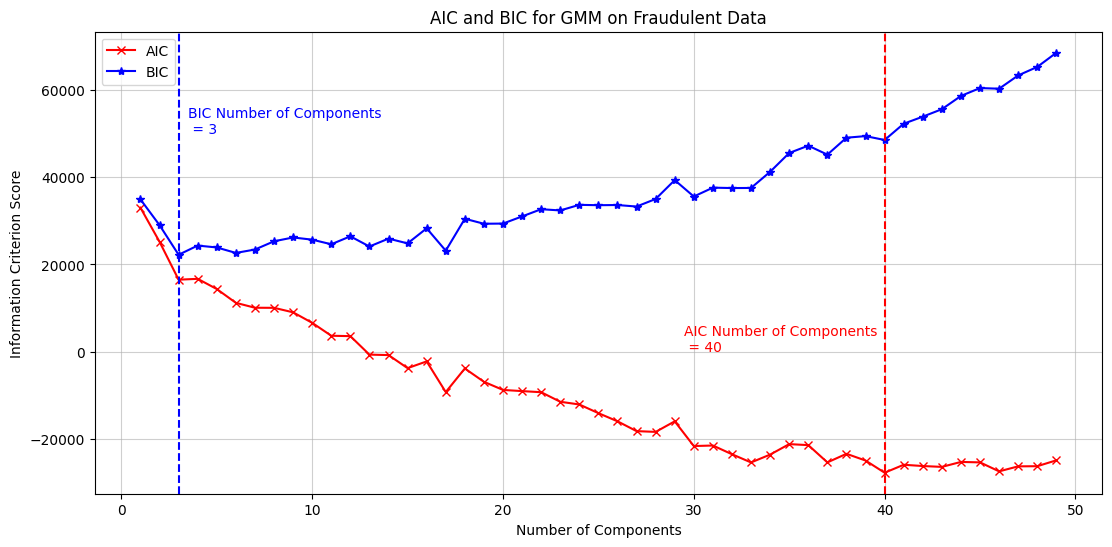

In [53]:
# Plot the AIC and BIC scores against the number of components.

plt.figure(figsize=(13,6))
plt.plot(num_comp, aic_gmm, label="AIC",color="red", marker = 'x') # AIC Plot.
plt.plot(num_comp, bic_gmm, label="BIC",color="blue", marker = '*') # BIC Plot.
plt.title("AIC and BIC for GMM on Fraudulent Data")
plt.xlabel("Number of Components")
plt.ylabel("Information Criterion Score")
plt.grid(True, linestyle='-', alpha=0.6)
plt.legend()

min_com_aic = np.argmin(np.array(aic_gmm))+1
min_com_bic = np.argmin(np.array(bic_gmm))+1

plt.axvline(x = min_com_aic, linestyle = '--', color = "red")
plt.axvline(x = min_com_bic, linestyle = '--', color = "blue")

plt.text(min_com_aic-10.5, 0, f"AIC Number of Components\n = {min_com_aic}", color="red")
plt.text(min_com_bic+0.5, 50000, f"BIC Number of Components\n = {min_com_bic}", color="blue")

plt.show()

#### Question 2.2 : Explain how you determined the optimal number of components (k) for the GMM. You can use a metric like the Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC) to justify your choice.

- To generate synthetic samples using a Gaussian Mixture Model (GMM), the optimal number of Gaussian components must first be determined.
- GMMs are fitted with different values of $K$ on the **scaled minority (fraudulent) class data**.  
- For each fitted model, the **Akaike Information Criterion (AIC)** and the **Bayesian Information Criterion (BIC)** are computed.  
- Both AIC and BIC balance **model fit** (likelihood) with **model complexity** (number of parameters).  
- **AIC**:  
  $$
  \text{AIC} = 2p - 2 \ln(\hat{L})
  $$  

- **BIC**:  
  $$
  \text{BIC} = p \ln(n) - 2 \ln(\hat{L})
  $$  

where:  
- $p$ = number of estimated parameters in the GMM  
- $n$ = number of samples in the minority class  
- $\hat{L}$ = maximized log-likelihood of the fitted model  

- AIC penalizes complexity lightly and often decreases continuously, favoring very large $K$.  
- BIC penalizes complexity more strongly and typically identifies a smaller, more stable $K$.  
- In this dataset, AIC suggested large values of $K$, which is not realistic.
- BIC reached its minimum at **$K = 3$**


- Both AIC and BIC were plotted to illustrate the trade-off.  
- The number of components is selected according to **BIC**, as it provides a conservative and reliable estimate for small, imbalanced datasets.  
- This ensures that the GMM captures the structure of the fraudulent class without overfitting to noise.  

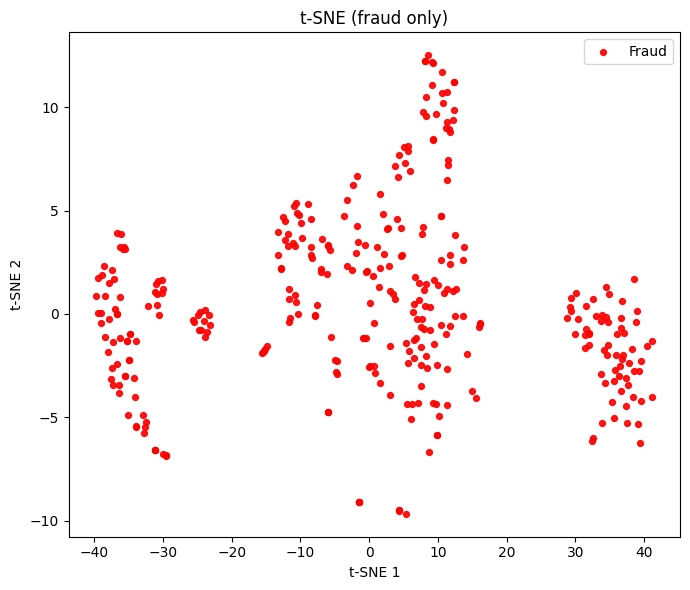

In [73]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne_fraud = tsne.fit_transform(X_train_fraud)

plt.figure(figsize=(7,6))
plt.scatter(X_tsne_fraud[:,0], X_tsne_fraud[:,1], s=18, alpha=0.9, color="red", label="Fraud")
plt.title("t-SNE (fraud only)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.legend(); plt.tight_layout(); plt.show()

### Question 3 : Synthetic Data Generation

#### Question 3.1 : Use the fitted GMM to generate a sufficient number of new synthetic samples to balance the dataset. Explain the process of sampling from a GMM.

In [79]:
# Function to generate synthetic minority samples using GMM
def gmm_generate_samples(X_minority, n_samples, n_components, random_state=42):
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type="full",
        random_state=random_state
    )
    gmm.fit(X_minority) # Fit a Gaussian Mixture Model on the minority class

    # Generate synthetic samples
    X_synthetic, comp_idx  = gmm.sample(n_samples)  # Generate synthetic samples from the fitted GMM
     
    return X_synthetic, comp_idx, gmm

In [80]:
n_min = X_train_scaled[y_train==1].shape[0] # number of fraud (minority) samples
n_maj = X_train_scaled[y_train==0].shape[0] # number of non-fraud (majority) samples
 
X_syn, syn_comp, gmm = gmm_generate_samples(X_train_fraud, n_samples=n_maj-n_min, n_components=3) # Generate synthetic fraud samples

#### Question 3.2 : Combine these newly generated samples with the original training data.

In [81]:
# Combine synthetic samples with the original training set.

X_train_gmm = np.vstack([X_train_scaled, X_syn]) # combine features.
y_train_gmm = np.hstack([y_train, np.ones(len(X_syn))]) # append labels for synthetic fraud (1).
y_train_gmm = pd.Series(y_train_gmm)

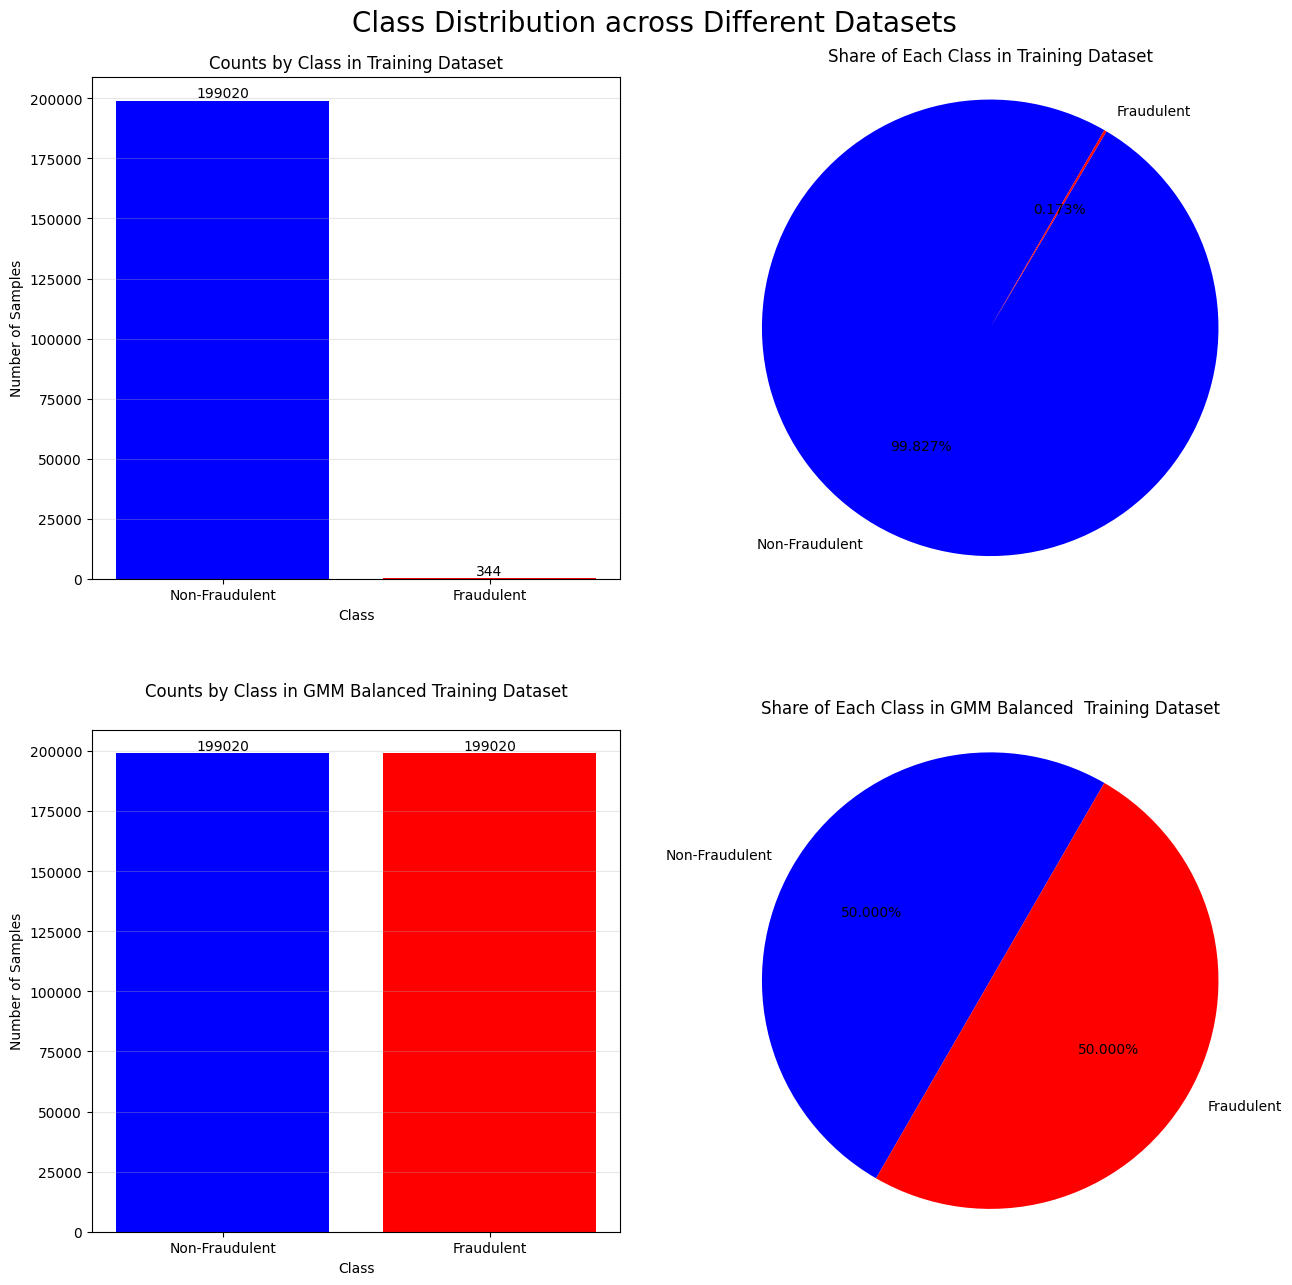

In [58]:
# Plot to show class distribution in Original, GMM Balanced Training, and Testing datasets.

# Count class samples in training and testing sets.
train_count_gmm = y_train_gmm.map(class_map).value_counts().reset_index()
train_count_gmm.columns = ['Class','count']

# Create grid for subplots.
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize=(15,15))
plt.subplots_adjust(hspace=0.3)  # Adjust vertical space between rows.
plt.suptitle("Class Distribution across Different Datasets", y = 0.925,  fontsize=20) # Plot's super title.

# Bar chart of class count for training dataset.
bars = ax[0][0].bar(train_count['Class'], train_count['count'], color = class_colors) 
ax[0][0].set_title("Counts by Class in Training Dataset")
ax[0][0].set_xlabel("Class")
ax[0][0].set_ylabel("Number of Samples")
ax[0][0].bar_label(bars)
ax[0][0].grid(axis='y', alpha=0.3)

# Pie chart of class count for training dataset.
ax[0][1].pie(train_count['count'], labels=train_count['Class'], colors = class_colors, autopct='%1.3f%%', startangle=60) 
ax[0][1].set_title("Share of Each Class in Training Dataset", y=1.015)
ax[0][1].axis('equal')

# Bar chart of class count for gmm balanced training dataset.
bars = ax[1][0].bar(train_count_gmm['Class'], train_count_gmm['count'], color = class_colors) 
ax[1][0].set_title("Counts by Class in GMM Balanced Training Dataset",  y=1.05)
ax[1][0].set_xlabel("Class")
ax[1][0].set_ylabel("Number of Samples")
ax[1][0].bar_label(bars)
ax[1][0].grid(axis='y', alpha=0.3)

# Pie chart of class count for gmm balanced training dataset.
ax[1][1].pie(train_count_gmm['count'], labels=train_count_gmm['Class'], colors = class_colors, autopct='%1.3f%%', startangle=60) 
ax[1][1].set_title("Share of Each Class in GMM Balanced  Training Dataset", y=1.015)
ax[1][1].axis('equal')
plt.show()

### Question 4 : Rebalancing with CBU

#### Question 4.1 : Use clustering-based Undersampling on the majority dataset to bring it down to a suitable population.

In [59]:
# Import ClusterCentroids for undersampling
from imblearn.under_sampling import ClusterCentroids

# Import KMeans for clustering analysis
from sklearn.cluster import KMeans

In [60]:
X_train_notfraud = X_train_scaled[y_train==0] # Extract the majority class (non-fraud) samples/
K_maj = range(1,51) # Define range of cluster counts (from 1 to 50).

wss_majority = [] # list to store inertia values.
for k in K_maj:
    kmeans_maj=KMeans(n_clusters=k, n_init='auto', random_state=0) # Initialize KMeans with k clusters
    kmeans_maj.fit(X_train_notfraud) # Fit clustering on non-fraud data.
    wss_majority.append(kmeans_maj.inertia_) # append inertia for each k.

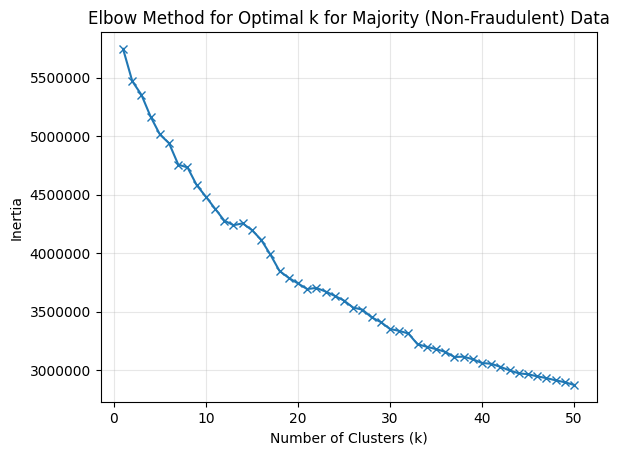

In [61]:
# Plot the Elbow Curve.

plt.plot(K_maj, wss_majority, marker = 'x')
plt.title("Elbow Method for Optimal k for Majority (Non-Fraudulent) Data")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True, alpha=0.3)
plt.show()

In [62]:
from imblearn.under_sampling import ClusterCentroids

k_opt_maj = 15 # Optimal k for majority clustering.

# Cluster-based undersampling.
maj_label = 0

# Set majority target size = 3 × number of minority samples (controlled undersampling).
target_maj_num = X_train_fraud.shape[0]*3

# Apply ClusterCentroids for undersampling.
cc = ClusterCentroids(
    sampling_strategy={maj_label: target_maj_num},
    estimator=KMeans(n_clusters=15, random_state=0, n_init='auto'),
    random_state=0
)

# Resample training data.
X_train_cbu_scaled, y_train_cbu = cc.fit_resample(X_train_scaled, y_train)

#### Question 4.2 : Use GMM-based synthetic sampling on the minority dataset to match the majority population and hence create a balanced dataset.

In [63]:
# Separate minority and majority samples after CBU.

X_min_cbu = X_train_cbu_scaled[y_train_cbu == 1]
X_maj_cbu = X_train_cbu_scaled[y_train_cbu == 0]

# Count minority and majority samples.

n_min_cbu = X_min_cbu.shape[0]
n_maj_cbu = X_maj_cbu.shape[0]

# Number of synthetic fraud samples needed to balance the dataset.
n_needed  = n_maj_cbu - n_min_cbu

In [64]:
# Fit GMM on minority data (X_min_cbu) and generate 'n_needed' synthetic samples.

X_syn_cbu = gmm_generate_samples(X_min_cbu, n_samples=n_needed, n_components=3)

In [65]:
# Combine original data with synthetic samples.

X_train_gmm_cbu= np.vstack([X_train_cbu_scaled, X_syn_cbu])
y_train_gmm_cbu= np.hstack([y_train_cbu, np.ones(n_needed, dtype=y_train_cbu.dtype)])

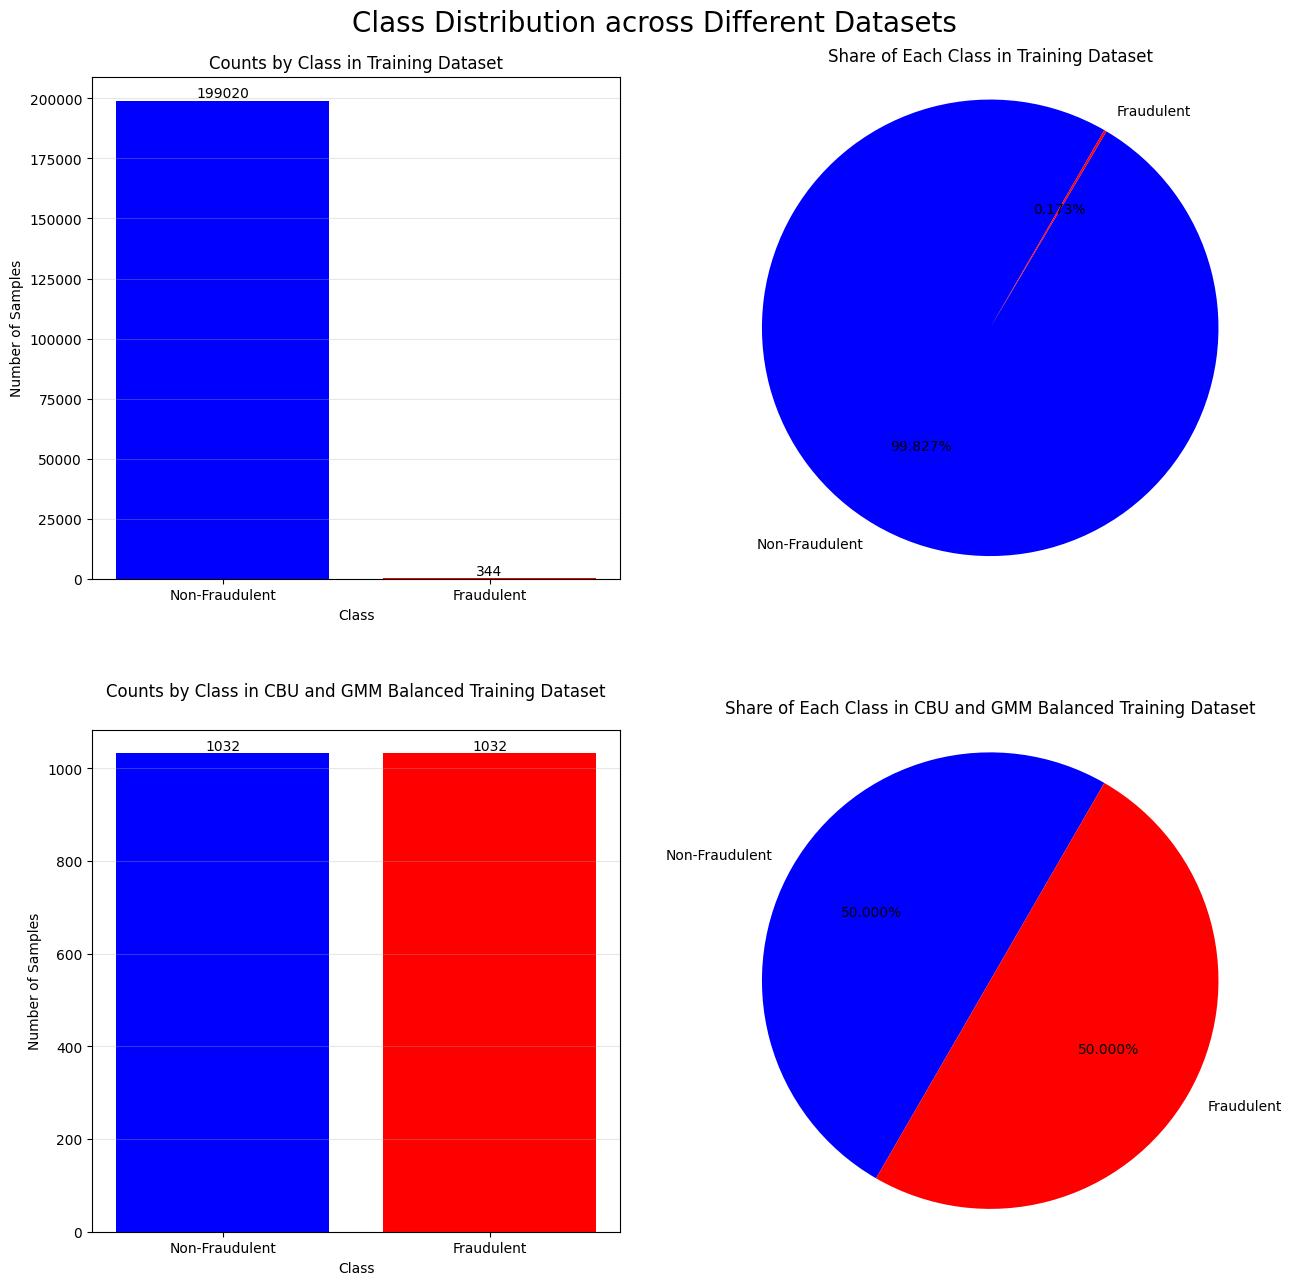

In [66]:
# Plot to show class distribution in Original, GMM Balanced Training, and Testing datasets.

# Count class samples in training and testing sets.
y_train_gmm_cbu = pd.Series(y_train_gmm_cbu)
train_count_gmm_cbu = y_train_gmm_cbu.map(class_map).value_counts().reset_index()
train_count_gmm_cbu.columns = ['Class','count']

# Create grid for subplots.
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize=(15,15))
plt.subplots_adjust(hspace=0.3)  # Adjust vertical space between rows.
plt.suptitle("Class Distribution across Different Datasets", y = 0.925,  fontsize=20) # Plot's super title.

# Bar chart of class count for training dataset.
bars = ax[0][0].bar(train_count['Class'], train_count['count'], color = class_colors) 
ax[0][0].set_title("Counts by Class in Training Dataset")
ax[0][0].set_xlabel("Class")
ax[0][0].set_ylabel("Number of Samples")
ax[0][0].bar_label(bars)
ax[0][0].grid(axis='y', alpha=0.3)

# Pie chart of class count for training dataset.
ax[0][1].pie(train_count['count'], labels=train_count['Class'], colors = class_colors, autopct='%1.3f%%', startangle=60) 
ax[0][1].set_title("Share of Each Class in Training Dataset", y=1.015)
ax[0][1].axis('equal')

# Bar chart of class count for abu and gmm balanced training dataset.
bars = ax[1][0].bar(train_count_gmm_cbu['Class'], train_count_gmm_cbu['count'], color = class_colors) 
ax[1][0].set_title("Counts by Class in CBU and GMM Balanced Training Dataset",  y=1.05)
ax[1][0].set_xlabel("Class")
ax[1][0].set_ylabel("Number of Samples")
ax[1][0].bar_label(bars)
ax[1][0].grid(axis='y', alpha=0.3)

# Pie chart of class count for cbu and gmm balanced training dataset.
ax[1][1].pie(train_count_gmm_cbu['count'], labels=train_count_gmm_cbu['Class'], colors = class_colors, autopct='%1.3f%%', startangle=60) 
ax[1][1].set_title("Share of Each Class in CBU and GMM Balanced Training Dataset", y=1.015)
ax[1][1].axis('equal')
plt.show()

---

## Part C: Performance Evaluation and Conclusion

### Question 1 : Model Training and Evaluation

#### Question 1.1 : Train a new Logistic Regression classifier on the GMM-balanced training data (both versions).

#### Question 1.2 : Evaluate the model's performance on the same, original, imbalanced test set from Part A.

In [67]:
# Import necessary metrics for model evaluation.

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)



GMM Oversampling Model Accuracy: 98.69 %

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Classification Report of GMM Oversampling Model: 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.10      0.85      0.18       148

    accuracy                           0.99     85443
   macro avg       0.55      0.92      0.59     85443
weighted avg       1.00      0.99      0.99     85443

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



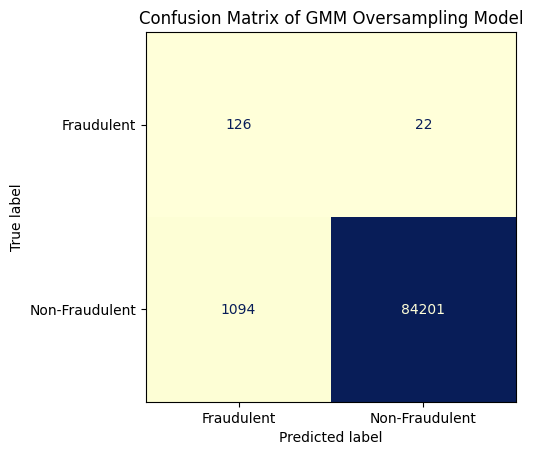

In [68]:
from sklearn.linear_model import LogisticRegression

clf_gmm = LogisticRegression(max_iter=10000, random_state=0) # Initialize Logistic Regression model.
clf_gmm.fit(X_train_gmm, y_train_gmm) # Train the model on the GMM-balanced training data

model_report(clf_gmm, X_test_scaled, y_test, "GMM Oversampling Model") # Evaluate model performance on the original test set.


CBU-GMM Model Accuracy: 97.46 %

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Classification Report of CBU-GMM Model: 

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.85      0.10       148

    accuracy                           0.97     85443
   macro avg       0.53      0.91      0.55     85443
weighted avg       1.00      0.97      0.99     85443

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 



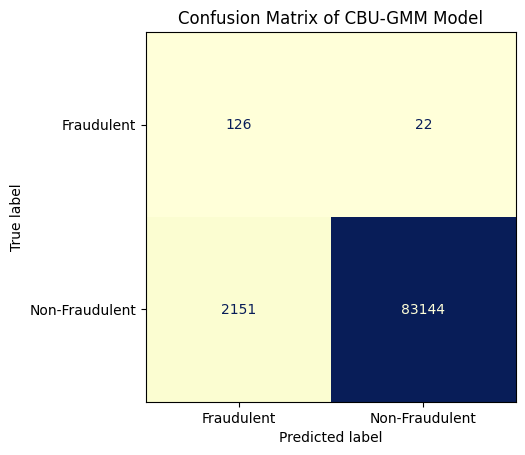

In [69]:
clf_gmm_cbu = LogisticRegression(max_iter=10000, random_state=0)
clf_gmm_cbu.fit(X_train_gmm_cbu, y_train_gmm_cbu)

model_report(clf_gmm_cbu, X_test_scaled, y_test, "CBU-GMM Model")

### Question 2 : Comparative Analysis 

#### Question 2.1 : Create a summary table or a bar chart comparing the Precision, Recall, and F1-score of the GMM-based model against the baseline model.

Comparison of Baseline vs GMM-Based Models (Minority Class Only)

| Model                | Precision | Recall | F1-score |
|-----------------------|-----------|--------|----------|
| Baseline Logistic     | 0.85      | 0.61   | 0.71     |
| GMM Oversampling      | 0.10      | 0.85   | 0.18     |
| CBU + GMM             | 0.06      | 0.85   | 0.10     |


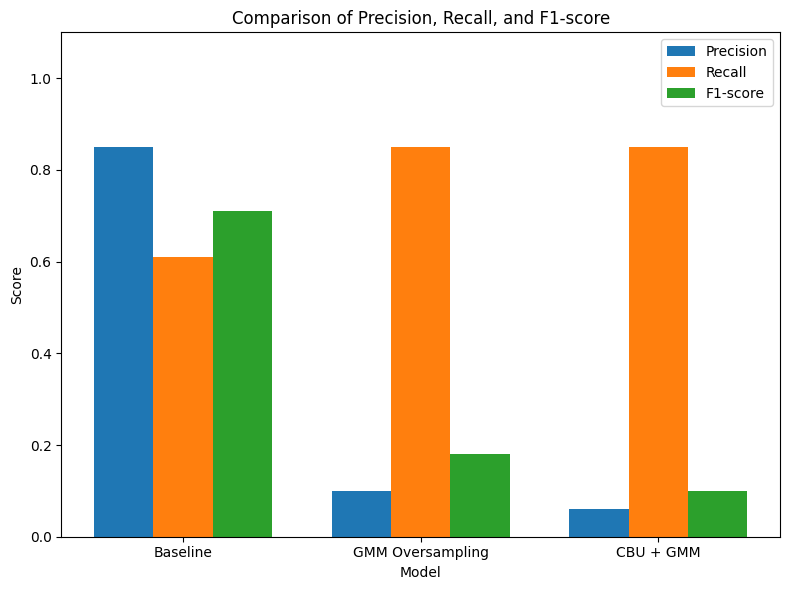

In [86]:
models = ["Baseline", "GMM Oversampling", "CBU + GMM"]
precision = [0.85, 0.10, 0.06]
recall    = [0.61, 0.85, 0.85]
f1        = [0.71, 0.18, 0.10]

# group positions
x = np.arange(len(models))
width = 0.25

# plot
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x - width, precision, width, label="Precision")
ax.bar(x, recall, width, label="Recall")
ax.bar(x + width, f1, width, label="F1-score")

# formatting
ax.set_ylabel("Score")
ax.set_xlabel("Model")
ax.set_title("Comparison of Precision, Recall, and F1-score")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

#### Question 2.2 : Discuss the impact of GMM-based oversampling on the classifier's performance. Did it improve the model's ability to detect the minority class?

- The **baseline model** achieved very high overall accuracy (**99.91%**), but this was misleading because it mainly favored the majority class (non-fraud).  
  - For the minority class (fraud), the baseline achieved **Precision = 0.85**, **Recall = 0.61**, and **F1-score = 0.71**.  
  - This indicates that many fraud cases were missed (low recall).  

- After applying **GMM-based oversampling**, the classifier showed a different trade-off:  
  - Minority class **Recall increased to 0.85**, meaning the model successfully detected more fraud cases.  
  - However, **Precision dropped sharply to 0.10**, leading to many false positives.  
  - The F1-score fell to **0.18**, showing that the gain in recall came at the cost of reduced precision.  

- With **CBU + GMM**, recall again remained high (**0.85**), but precision dropped further (**0.06**), and F1-score became very low (**0.10**).  

- **GMM oversampling improved the model’s ability to detect the minority class**, as seen from the large increase in recall (from 0.61 → 0.85).  
- However, this improvement came at the expense of **precision**, causing many false alarms.  
- In practice, the choice depends on application requirements:  
  - If **catching all frauds is critical**, high recall is beneficial, even with more false positives.  
  - If **minimizing false alarms is important**, the low precision becomes problematic.  
- Overall, GMM oversampling makes the classifier **more sensitive to fraud detection**, but less precise in distinguishing fraud from non-fraud.

### Question 3 : Final Recommendation

#### Question 3.1 : Based on your analysis, provide a clear recommendation on the effectiveness of using GMM for synthetic data generation in this context. Justify your answer using both your results and your theoretical understanding of the method.

- A Gaussian Mixture Model (GMM) is a probabilistic approach that can capture **multi-modal and complex distributions** of the minority class.  
- By sampling from the learned mixture distribution, GMM can generate synthetic points that are **statistically consistent** with the original fraud data.  
- This makes GMM more flexible than linear interpolation methods such as SMOTE, especially when the minority class exhibits **clusters or sub-groups**.  

- The **baseline model** detected only 61% of fraud cases (Recall = 0.61), missing many fraudulent transactions.  
- With **GMM oversampling**, Recall improved significantly to **0.85**, meaning the model became more sensitive to fraud detection.  
- However, Precision dropped drastically (0.85 → 0.10), leading to a large number of false alarms.  
- The **CBU+GMM approach** also achieved high Recall (0.85) but showed even lower Precision, with overall F1-scores decreasing.  


- GMM oversampling is **effective in improving the model’s ability to detect the minority class** (fraud) by boosting Recall.  
- However, the method introduces a severe **precision–recall trade-off**, where the model flags many normal transactions as fraud.  
- In fraud detection, this trade-off can be acceptable if the priority is to **catch as many frauds as possible** (high Recall), but it may be problematic if **false alarms are costly**.  
- A practical recommendation is to **combine GMM oversampling with additional filtering or ensemble methods** to control false positives.  


GMM-based synthetic sampling is **theoretically sound and empirically improves Recall**, but in practice it must be carefully balanced with techniques that preserve Precision. It is **not sufficient on its own** but can be a useful component of a broader fraud detection pipeline.